In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# JAX
import jax
import jax.numpy as jnp
import jraph
import numpy as np
import haiku as hk
import optax

# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

import loss
from model import VGAE
from dataset import draw_jraph_graph_structure

In [18]:
rng_key = jax.random.PRNGKey(42)

In [19]:
def plot_samps(draws, columns=4, rows=3, figsize = (19,12), ttl="CAR priors", custom_min: int = None, custom_max: int = None):
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    for r in range(rows):
        for c in range(columns):
            im = axs[r, c].imshow(draws[r*columns + c].reshape(num_y, num_x), 
                                  cmap='viridis', interpolation='none', #extent=[0,1,0,1], 
                                  origin='lower', 
                                  vmin=custom_min, vmax=custom_max)
            axs[r, c].set_title("draw "+str(r*columns + c))  
            fig.colorbar(im, ax=axs[r, c])
    fig.suptitle(ttl, fontsize=16)
    plt.show()
    
def plot_truth_estimate(y_true, mean_post_pred_vae, ttl1="Ground truth", ttl2="CAR estimate"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    _min, _max = np.amin([y_true, mean_post_pred_vae]), np.amax([y_true, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2) 
    
def plot_truth_car_vae(y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Ground truth", ttl2="CAR estimate", ttl3="VAE estimate"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    _min = np.amin([y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_car.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2)
    
    im = axs[2].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[2])
    axs[2].set_title(ttl3)

In [20]:
# Grid.
k = 1
num_x = 15 * k
num_y = 10 * k

# Polygons.
pols = []
for j in range(num_y):
  for i in range(num_x):
    coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
    p = Polygon(coords)
    pols.append(p)
    
N = len(pols)

# Adjacency matrix.
A = np.zeros(shape=(N,N))
for i in range(N):
  for j in range(i+1,N):
    if (pols[i].intersection(pols[j]).length > 0):
      A[i,j] = 1
      A[j,i] = 1

# Number of neighbours.
d = A.sum(axis=0)
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [21]:
def CAR(args):
  A = args["A"]
  d = args["d"]
  D = jnp.diag(d)

  #alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha * A)
  car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))

In [22]:
args = {# data
  "d": d,
  "A": A,
  "batch_size": 400,
}

In [23]:
# CAR: prior predictive
rng_key, car_pred_rng = jax.random.split(rng_key)

car_predictive = Predictive(CAR, num_samples=args["batch_size"])
car_preds = car_predictive(car_pred_rng, args)
car_draws = car_preds['car']

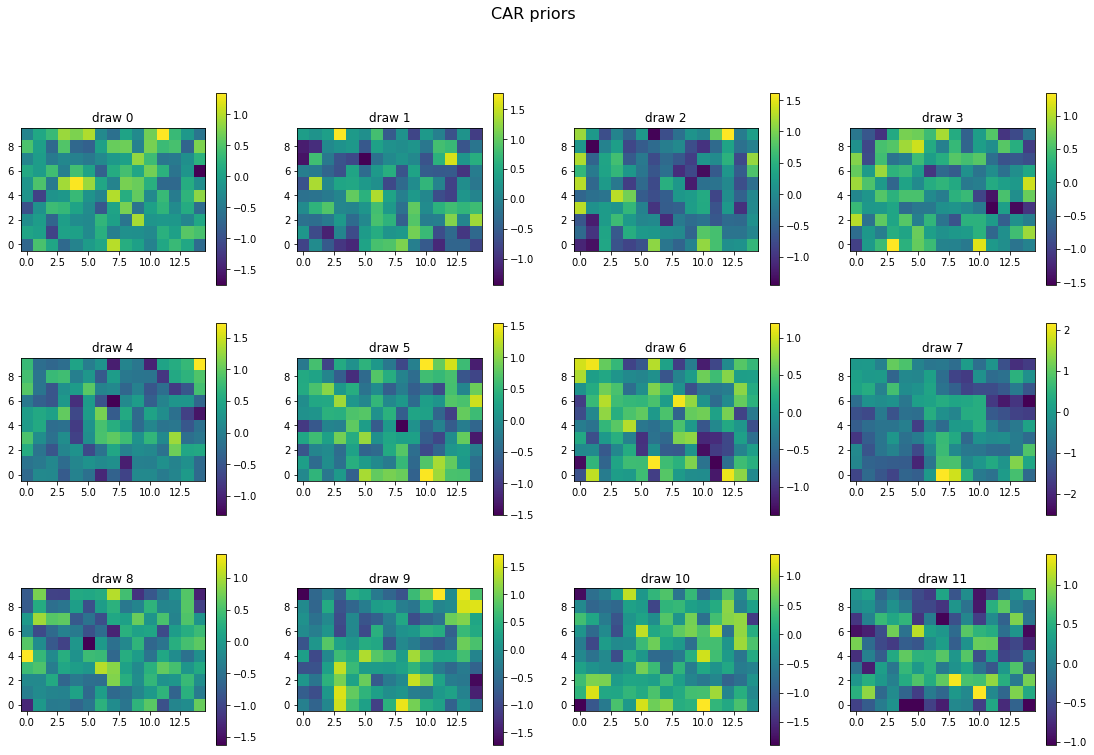

In [24]:
plot_samps(car_draws)

In [25]:
def create_grid_graph(adj_matrix: np.ndarray = None) -> jraph.GraphsTuple:
  if adj_matrix is None:
    adj_matrix = A
  G = nx.from_numpy_matrix(adj_matrix)

  edges = list(G.edges)
  edges += [(edge[1], edge[0]) for edge in edges]
  senders = jnp.asarray([edge[0] for edge in edges])
  receivers = jnp.asarray([edge[1] for edge in edges])

  return jraph.GraphsTuple(
    n_node = jnp.asarray([len(G.nodes)]),
    n_edge = jnp.asarray([len(edges)]),
    nodes=None,
    edges=None,
    globals=None,
    senders=senders, 
    receivers=receivers)

def get_car_draws_as_graph(car_draws: jnp.ndarray) -> jraph.GraphsTuple:
  graph = create_grid_graph()
  return graph._replace(nodes=car_draws)
  
dataset_graphs = []
dataset = []
for i in range(args['batch_size']):
  g = get_car_draws_as_graph(car_draws[i].reshape(-1, 1))
  dataset_graphs.append(g)
  dataset.append({
    'input_graph': g, 
    'target': g.nodes,
  })

train_size = int(len(dataset) * 0.6)
train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:]

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))

Train size: 240
Validation size: 160


In [26]:
# Batching
train_dataset_graphs = dataset_graphs[:train_size]
val_dataset_graphs = dataset_graphs[train_size:]
train_graph_batch = jraph.batch(train_dataset_graphs)
val_graph_batch = jraph.batch(val_dataset_graphs)

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [27]:
# See graph statistics for a single graph
train_graph = train_dataset[0]['input_graph']
train_labels = train_graph.nodes

num_nodes = train_graph.n_node.item()
feat_matrix_dim = train_graph.nodes.shape
assert num_nodes == feat_matrix_dim[0], 'num_nodes != feat_matrix_dim[0]'
assert feat_matrix_dim == train_labels.shape, 'feat_matrix_dim != train_labels.shape'
print('Number of nodes:', num_nodes)
print('Feature matrix dim (n_node x n_feat):', feat_matrix_dim)
print('Targets shape:', train_labels.shape)

Number of nodes: 150
Feature matrix dim (n_node x n_feat): (150, 1)
Targets shape: (150, 1)


In [28]:
from typing import NamedTuple, Callable

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun
  hidden_dim: int = 32
  latent_dim: int = 16
  output_dim: int = train_labels.shape[1]
  learning_rate: float = 1e-2
  epochs: int = 200
  eval_frequency: int = 10
  num_nodes: int = num_nodes

# Loss options include:
# [
#   loss.compute_mse_loss,
#   loss.compute_frobenius_loss,
#   loss.compute_L21_loss,
#   loss.compute_Lpq_loss,
# ]
wargs = Args(loss_fn=loss.compute_mse_loss)
print(wargs)

Args(loss_fn=<function compute_mse_loss at 0x165d890d0>, hidden_dim=32, latent_dim=16, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150)


In [29]:
rng_key, params_key = jax.random.split(rng_key)

# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=wargs.hidden_dim, 
                 latent_dim=wargs.latent_dim, 
                 output_dim=wargs.output_dim)(x))
optimizer = optax.adam(wargs.learning_rate)

In [30]:
from model import VGAEOutput
import loss
from loss import compute_kl_gaussian

@jax.jit
def loss_fn(params: hk.Params, 
            rng_key: jnp.ndarray,
            graph: jraph.GraphsTuple,
            targets: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood_loss_fn = wargs.loss_fn
  log_likelihood = -log_likelihood_loss_fn(
    outputs.output.nodes, targets)
  kld = 1/num_nodes * jnp.mean(
    compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  return -elbo
  
@jax.jit
def update(
params: hk.Params,
rng_key: jnp.ndarray,
opt_state: optax.OptState,
graph: jraph.GraphsTuple,
targets: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph, targets)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [31]:
# Initialize net with an arbitrary graph in dataset
init_graph = train_dataset[0]['input_graph']
params = net.init(params_key, init_graph)
opt_state = optimizer.init(params)

rng_key, train_rng = jax.random.split(rng_key)

train_losses = []
val_losses = []

start_time = time.time()
print('using: ', wargs.loss_fn)
for epoch in range(wargs.epochs):    
  update_rng = jax.random.fold_in(train_rng, epoch)
  train_target_batch = train_graph_batch.nodes
    
  params, opt_state = update(params, update_rng, opt_state, 
                             train_graph_batch, train_target_batch)

  if epoch % wargs.eval_frequency == 0 or epoch == (wargs.epochs - 1):
    loss_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(loss_rng)
    train_loss = loss_fn(params, train_loss_rng, train_graph_batch, train_target_batch)

    val_target_batch = val_graph_batch.nodes
    val_loss = loss_fn(params, eval_loss_rng, val_graph_batch, val_target_batch)
    
    print(f'epoch: {epoch}, train_loss: {train_loss:.3f}, val_loss: {val_loss:.3f}')
    
    if (len(train_losses) > 1) and (np.isclose(train_loss, train_losses[-1])):
      break
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

print(f'Total training time: {time.time() - start_time:.2f} s')

using:  <function compute_mse_loss at 0x165d890d0>
epoch: 0, train_loss: 0.365, val_loss: 0.352
epoch: 10, train_loss: 0.273, val_loss: 0.270
epoch: 20, train_loss: 0.255, val_loss: 0.251
epoch: 30, train_loss: 0.252, val_loss: 0.250
epoch: 40, train_loss: 0.251, val_loss: 0.249
epoch: 50, train_loss: 0.251, val_loss: 0.247
epoch: 60, train_loss: 0.250, val_loss: 0.247
epoch: 70, train_loss: 0.250, val_loss: 0.248
epoch: 80, train_loss: 0.249, val_loss: 0.247
epoch: 90, train_loss: 0.250, val_loss: 0.247
epoch: 100, train_loss: 0.248, val_loss: 0.246
epoch: 110, train_loss: 0.248, val_loss: 0.245
epoch: 120, train_loss: 0.248, val_loss: 0.244
epoch: 130, train_loss: 0.247, val_loss: 0.244
epoch: 140, train_loss: 0.247, val_loss: 0.244
epoch: 150, train_loss: 0.246, val_loss: 0.243
epoch: 160, train_loss: 0.245, val_loss: 0.243
epoch: 170, train_loss: 0.245, val_loss: 0.242
epoch: 180, train_loss: 0.245, val_loss: 0.242
epoch: 190, train_loss: 0.244, val_loss: 0.242
epoch: 199, train_lo

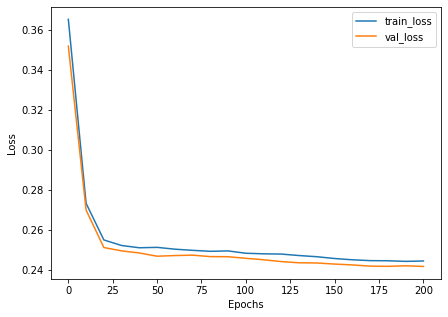

In [32]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(7, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xs = np.arange(len(train_losses))*wargs.eval_frequency
plt.plot(xs, train_losses, label='train_loss')
plt.plot(xs, val_losses, label='val_loss')

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

In [33]:
from model import prior_decode
from functools import partial

decoder_params = {
  'decoder_hidden': params['vgae/decoder_hidden'],
  'decoder_output': params['vgae/decoder_output'],
}

decoder_net_fn = partial(prior_decode, hidden_dim=wargs.hidden_dim, output_dim=wargs.output_dim)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

rng_key, z_rng = jax.random.split(rng_key)

rng_key, *sample_rngs = jax.random.split(rng_key, args['batch_size']+1)

vae_draws = []
for idx in range(args['batch_size']):
  z_rng_idx = jax.random.fold_in(z_rng, idx)
  z = jax.random.normal(z_rng_idx, shape=(wargs.num_nodes, wargs.latent_dim))
  z_graph = create_grid_graph()._replace(nodes=z)  # this step assumes only node features are used.
  out_graph = decoder_net.apply(decoder_params, z_graph)
  vae_draws.append(out_graph.nodes)

vae_draws = jnp.squeeze(jnp.asarray(vae_draws))
assert vae_draws.shape == car_draws.shape, 'vae_draws dimensions do not match car_draws dimensions'

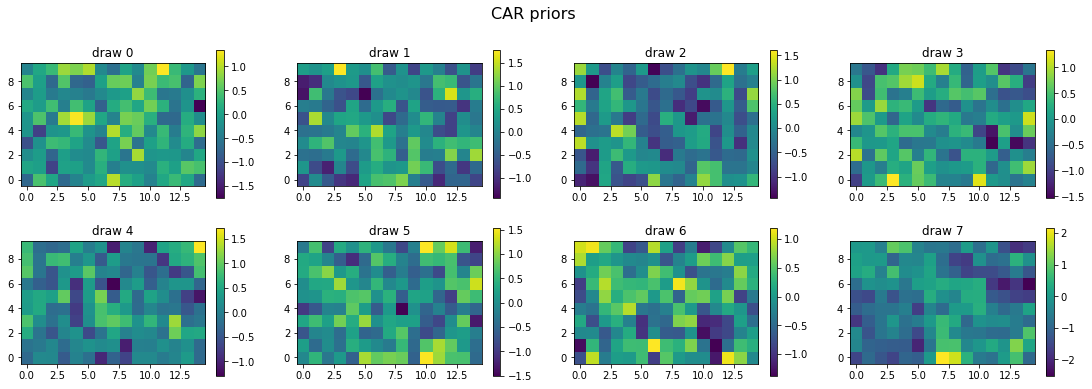

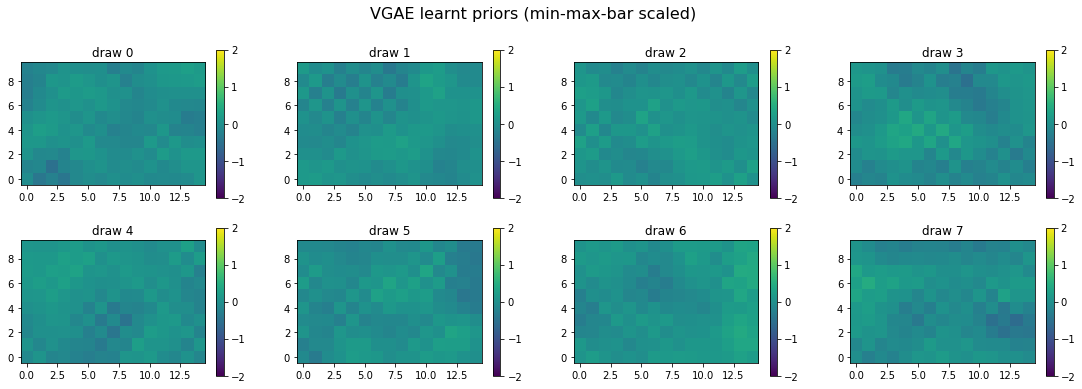

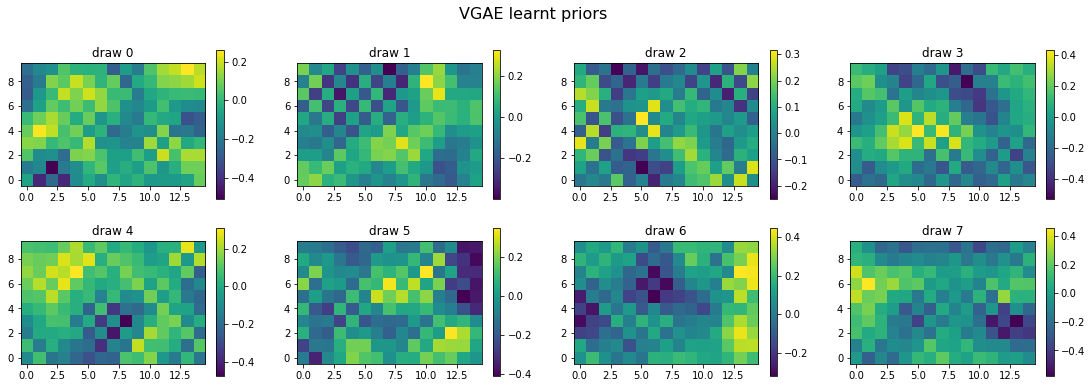

In [34]:
plot_samps(car_draws, rows=2, figsize=(19, 6))
plot_samps(vae_draws, rows=2, figsize=(19, 6), ttl='VGAE learnt priors (min-max-bar scaled)', custom_min=-2, custom_max=2)
plot_samps(vae_draws, rows=2, figsize=(19, 6), ttl='VGAE learnt priors')

In [35]:
print(wargs)

Args(loss_fn=<function compute_mse_loss at 0x165d890d0>, hidden_dim=32, latent_dim=16, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150)


### Inference on observed data with VGAE-CAR

In [36]:
args['decoder_params'] = decoder_params

In [37]:
def CAR_model(args, y=None, alpha=None, noise=None):
    
    A = args["A"]
    d = args["d"]
    D = jnp.diag(d)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha * A)
    
    car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))
    car_samples = numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car, noise), obs=y)

In [38]:
# generate ground truth - fix alpha
rng_key, rng_key_truth = jax.random.split(rng_key)
car_predictive = Predictive(CAR_model, num_samples=1)
car_preds = car_predictive(rng_key_truth, args, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

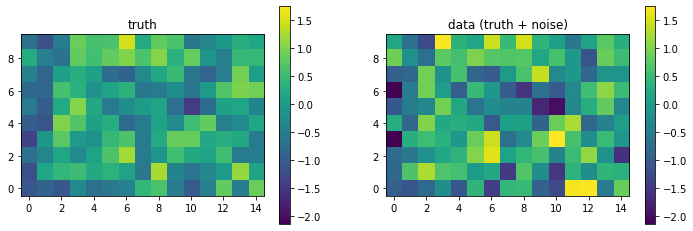

In [39]:
plot_truth_estimate(y_truth, y_data, ttl1="truth", ttl2="data (truth + noise)")

In [40]:
args['hidden_dim'] = wargs.hidden_dim
args['latent_dim'] = wargs.latent_dim
args['output_dim'] = wargs.output_dim
args['train_graph'] = train_graph
args['n_node'] = wargs.num_nodes
args['decoder_net'] = decoder_net

In [41]:
def VAE_model(args, y=None, noise=None):
    z = numpyro.sample("z", dist.Normal(0, 1).expand([args['n_node'], args['latent_dim']]))
    z_graph = create_grid_graph()._replace(nodes=z)  # this step assumes only node features are used.
    
    decoder_params = args["decoder_params"] 
    car_vae = numpyro.deterministic(
        "vae_car", 
        # The transpose is because we initially used 
        # more than one samples ~ N(0, 1) as features for each node
        jnp.squeeze(decoder_net.apply(decoder_params, z_graph).nodes.T))
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car_vae, noise), obs=y)

In [42]:
# VAE-CAR: prior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
prior_predictive = Predictive(VAE_model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, args)
pred_obs = prior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_prior_pred_vae = np.mean(pred_obs, axis=0)
# Original VAE used: mean_prior_pred_vae = np.mean(pred_obs, axis=0)

hpdi_prior_pred_vae = hpdi(pred_obs, 0.89)

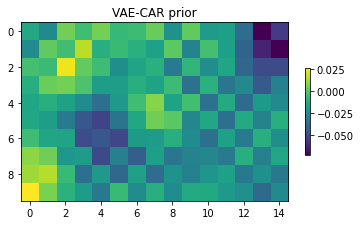

In [43]:
plt.figure()
plt.imshow(mean_prior_pred_vae.reshape(num_y, num_x)) 
plt.colorbar(shrink=0.4)
plt.title("VAE-CAR prior")
plt.show()

In [44]:
# inference
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(VAE_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = jax.random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [00:15<00:00, 188.61it/s, 31 steps of size 2.02e-01. acc. prob=0.87]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       noise      0.82      0.05      0.82      0.74      0.90   1942.25      1.00
  vae_car[0]     -0.11      0.16     -0.11     -0.37      0.14   3692.63      1.00
  vae_car[1]     -0.12      0.17     -0.11     -0.41      0.14   3313.79      1.00
  vae_car[2]     -0.06      0.15     -0.06     -0.31      0.19   4020.00      1.00
  vae_car[3]     -0.01      0.15     -0.02     -0.25      0.23   3229.30      1.00
  vae_car[4]     -0.04      0.15     -0.04     -0.29      0.20   3871.15      1.00
  vae_car[5]      0.00      0.15      0.00     -0.24      0.25   3119.59      1.00
  vae_car[6]     -0.06      0.15     -0.06     -0.30      0.19   3709.67      1.00
  vae_car[7]     -0.02      0.15     -0.02     -0.26      0.22   3871.13      1.00
  vae_car[8]     -0.07      0.15     -0.08     -0.33      0.15   3900.66      1.00
  vae_car[9]     -0.04      0.15     -0.04     -0.29      0.20   4310.04      1.00
 va

In [45]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 19 s
Average ESS for all CAR effects : 3904


In [46]:
mcmc_samples.keys()

dict_keys(['noise', 'vae_car', 'z'])

In [47]:
# posterior predictive
rng_key, rng_key_ = jax.random.split(rng_key)
posterior_predictive = Predictive(VAE_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_, args)
post_obs = posterior_predictions['vae_car']

# Take mean over axis=0 (num_samples) and then over axis=1 (batch_size)
mean_post_pred_vae = np.mean(post_obs, axis=0)
bci_vae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

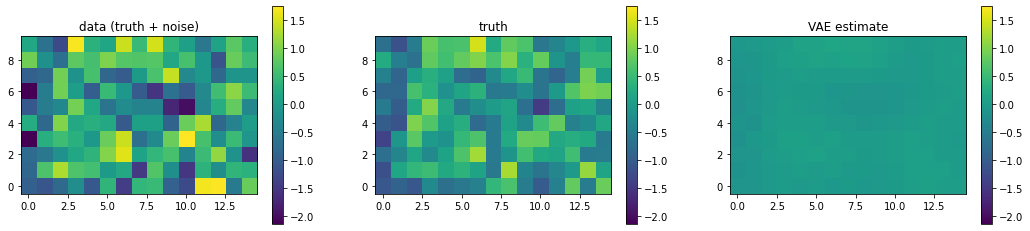

In [48]:
plot_truth_car_vae(y_data, y_truth, 
                   mean_post_pred_vae, 
                   ttl1="data (truth + noise)", ttl2="truth", ttl3="VAE estimate")

Text(0, 0.5, 'VAE post. predictive')

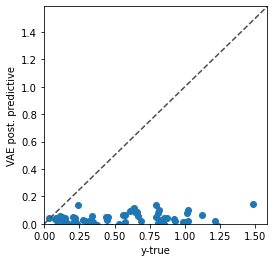

In [49]:
mx = np.max([y_truth, mean_post_pred_vae])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_vae)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("VAE post. predictive")

In [50]:
MSE_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(MSE_vae)

0.35074463


In [51]:
print(wargs)

Args(loss_fn=<function compute_mse_loss at 0x165d890d0>, hidden_dim=32, latent_dim=16, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150)


### Inference with CAR

In [52]:
# inference - smooth data and infer alpha
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(CAR_model, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
rng_key, rng_key_infer = jax.random.split(rng_key)
mcmc.run(rng_key_infer, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [03:57<00:00, 12.63it/s, 15 steps of size 3.00e-01. acc. prob=0.90]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      0.73      0.13      0.75      0.51      0.93   1401.12      1.00
          car[0]     -0.75      0.47     -0.73     -1.44      0.09   4066.93      1.00
          car[1]     -0.68      0.40     -0.68     -1.32     -0.02   2944.42      1.00
          car[2]     -0.44      0.40     -0.44     -1.18      0.16   2909.11      1.00
          car[3]     -0.18      0.41     -0.18     -0.83      0.53   3156.37      1.00
          car[4]     -0.52      0.44     -0.52     -1.27      0.15   4841.69      1.00
          car[5]      0.07      0.41      0.06     -0.62      0.74   3774.56      1.00
          car[6]     -0.69      0.41     -0.69     -1.36     -0.01   3409.32      1.00
          car[7]      0.09      0.42      0.09     -0.61      0.76   4121.29      1.00
          car[8]      0.22      0.42      0.22     -0.50      0.87   3764.97      1.00
          car[9]     -0.54      0.43     -

In [53]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 239 s
Average ESS for all CAR effects : 3779


In [54]:
mcmc_samples.keys()

dict_keys(['alpha', 'car', 'car_samples', 'noise'])

In [55]:
# posterior predictive
rng_key, rng_key_predict = jax.random.split(rng_key)
posterior_predictive = Predictive(CAR_model, mcmc_samples)
posterior_predictions = posterior_predictive(rng_key_predict, args, y=None)

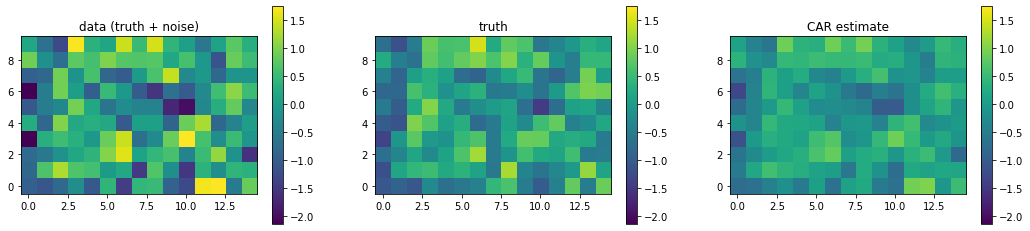

In [56]:
post_obs = posterior_predictions['car_samples']
mean_post_pred_car = np.mean(post_obs, axis=0)
bci_car_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_car_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_car = hpdi(post_obs, 0.9)

plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_car, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="CAR estimate")

0.14233461


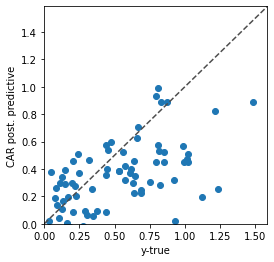

In [57]:
mx = np.max([y_truth, mean_post_pred_car])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(y_truth, mean_post_pred_car)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("y-true")
plt.ylabel("CAR post. predictive")

MSE_car = np.mean((y_truth -  mean_post_pred_car)**2)
print(MSE_car)

Text(0, 0.5, 'CAR post. predictive')

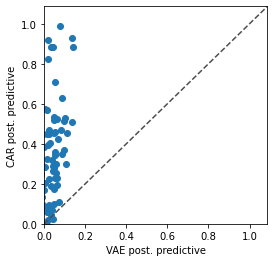

In [58]:
mx = np.max([ mean_post_pred_vae, mean_post_pred_car])
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(mean_post_pred_vae, mean_post_pred_car)
plt.ylim(0, mx+0.1)
plt.xlim(0, mx+0.1)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("VAE post. predictive")
plt.ylabel("CAR post. predictive")

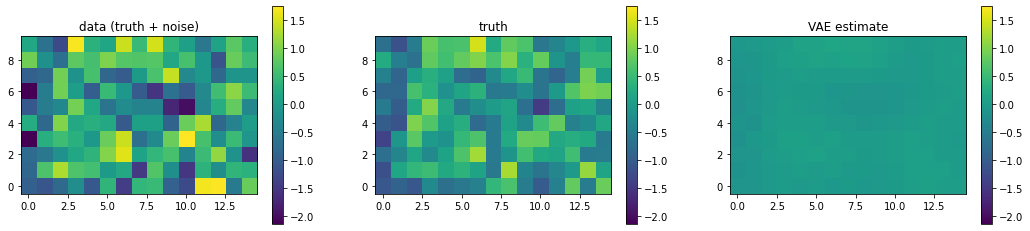

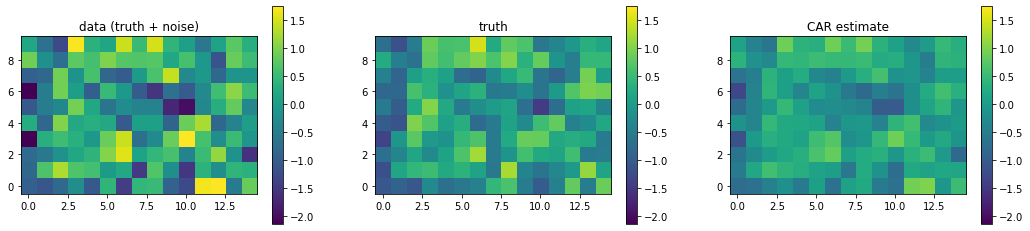

In [59]:
plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_vae, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="VAE estimate")

plot_truth_car_vae(y_data, 
                   y_truth, 
                   mean_post_pred_car, 
                   ttl1="data (truth + noise)", 
                   ttl2="truth", 
                   ttl3="CAR estimate")

In [60]:
def plot_data_truth_car_vae(y_data, y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Data", ttl2="Ground truth", ttl3="CAR estimate", ttl4="VAE-CAR estimate"):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    _min = np.amin([y_data, y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_data, y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0,0].imshow(y_data.reshape(num_y, num_x), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0,0])
    axs[0,0].set_title(ttl1)  

    im = axs[0,1].imshow(y_true.reshape(num_y, num_x), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[0,1])
    axs[0,1].set_title(ttl2)
    
    im = axs[1,0].imshow(mean_post_pred_car.reshape(num_y, num_x), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1,0])
    axs[1,0].set_title(ttl3)
    
    im = axs[1,1].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='inferno', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1,1])
    axs[1,1].set_title(ttl4)
    
    return fig

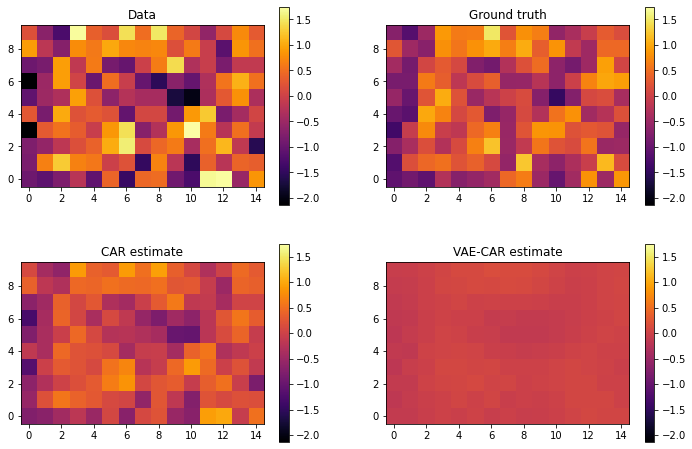

In [61]:
fig = plot_data_truth_car_vae(y_data, 
                        y_truth, 
                        mean_post_pred_car,
                        mean_post_pred_vae)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# fig.savefig("figures/synth_CAR.pdf")

In [62]:
mean_post_pred_car.shape

(150,)

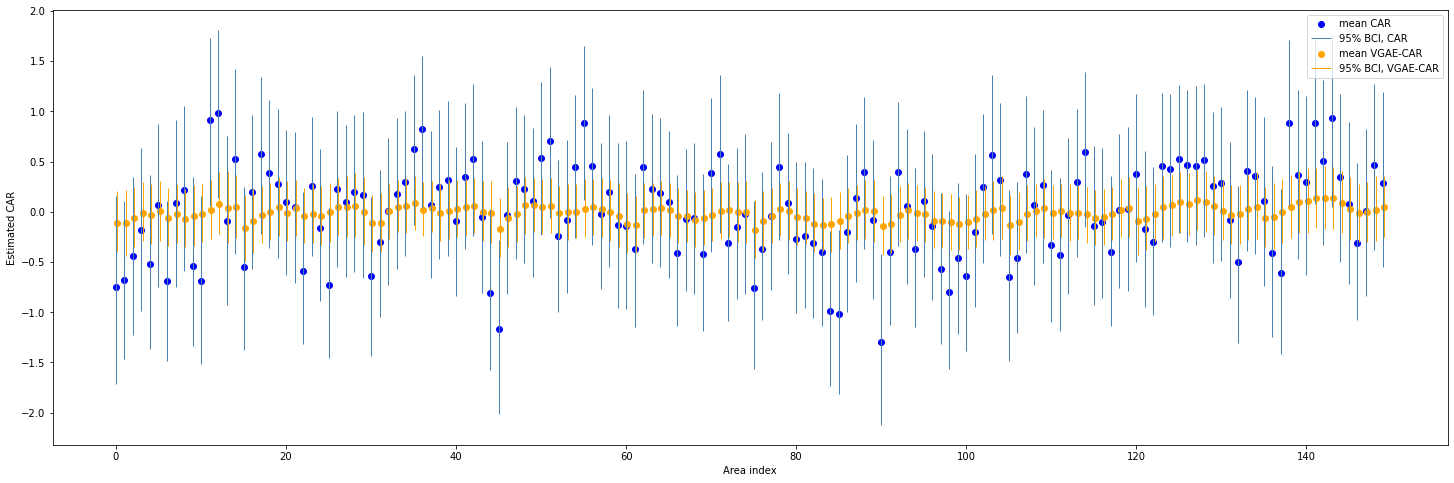

In [63]:
_, ax = plt.subplots(figsize=(25, 8))

xs = np.arange(0, num_x*num_y)
ax.scatter(xs, mean_post_pred_car, label="mean CAR", color='blue')
ax.vlines(xs, bci_car_2_5, bci_car_97_5, linestyle="-",  linewidth=1, color='steelblue', label='95% BCI, CAR')
ax.scatter(xs+0.15, mean_post_pred_vae, label="mean VGAE-CAR", color='orange')
ax.vlines(xs+0.15, bci_vae_2_5, bci_vae_97_5, linestyle="-", linewidth=1, color='orange', label='95% BCI, VGAE-CAR')

ax.set_xlabel('Area index')
ax.set_ylabel('Estimated CAR')

plt.legend()
plt.show()

In [64]:
print(wargs)

Args(loss_fn=<function compute_mse_loss at 0x165d890d0>, hidden_dim=32, latent_dim=16, output_dim=1, learning_rate=0.01, epochs=200, eval_frequency=10, num_nodes=150)
